# Demonstration of Symplectic Transformations for MGO

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from IPython.display import display, Math, Latex
from scipy.integrate import solve_ivp
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, FloatSlider

%matplotlib widget

## Dispersion Symbols

In [14]:
x0, k0 = 1, 0
x_sym, k_sym = sp.symbols('x k')

names = ['Airy', 'Weber', 'Himmelblau']
def get_H(name, params=None):
    if name == 'Airy':
        H = lambda x, k: (x-1) + k**2
    if name == 'Weber':
        H = lambda x, k: x**2 + k**2 - 1
    if name == 'Himmelblau':
        H1 = lambda x, k: (x**2 + k - 11)
        H2 = lambda x, k: (x + k**2 - 7)
        offset = H1(x0,k0)**2 + H2(x0,k0)**2
        H = lambda x, k: -1/50*(H1(x,k)**2 + H2(x,k)**2 - offset)
    # if name == 'Multigaussian':
    #     if params is None:
    #         N, R, l = 4, 1, 0.7
    #     else:
    #         N, R, l = params
    #     zns = [sp.Matrix([R*sp.cos(n*2*sp.pi/N), R*sp.sin(n*2*sp.pi/N)]) for n in range(1,N+1)]
    #     H = lambda x, k: -sp.Rational(1, 2) + sum(sp.exp(-((x - zn[0])**2 + (k - zn[1])**2)/l**2) for zn in zns)
    return H

t_spans = {'Airy': [-np.sqrt(6)/2, np.sqrt(6)/2], 'Weber': [0, np.pi], 'Himmelblau': [0, 18.52]}

## Utility functions to calculate derivatives with symbolic differentiation

In [15]:
def get_dH_sp(H_sp):
    dH = sp.Matrix([sp.diff(H_sp, v) for v in (x_sym, k_sym)])
    return dH

def get_ddH_sp(H_sp):
    ddH = sp.hessian(H_sp, (x_sym, k_sym))
    return ddH

J_sp = sp.Matrix([[0, 1], [-1, 0]])
J_np = np.array(J_sp).astype(np.int16)

def zdot(dH_sp):
    zdot = J_sp @ dH_sp
    return zdot

def zddot(ddH_sp, zdot_sp):
    zddot = J_sp @ ddH_sp @ zdot_sp
    return zddot

# solve the system of ODEs with zdot as the right-hand side
def trace_ray(zdot, z0, t_span=[0, 10], nt=100):
    t_eval = np.linspace(t_span[0], t_span[1], nt)
    sol = solve_ivp(lambda t, z: zdot(z[0], z[1]).squeeze(), t_span, z0, t_eval=t_eval, method='RK45', rtol=1e-6, atol=1e-6)
    return sol.t, sol.y

def to_func(*f_sps):
    """Convert one or more sympy functions to numpy functions."""
    funcs = [sp.lambdify((x_sym, k_sym), f_sp, modules='numpy') for f_sp in f_sps]
    if len(funcs) == 1:
        return funcs[0]
    return tuple(funcs)

## Utility functions

These functions enable us to choose a Hamiltonian $H_z$ and a reference time point index `it` and then calculate the symplectic transformation diagonalizing the Hessian of $H_z$.

In [17]:
def choose_H(name):
    global H, H_sp, dH_sp, ddH_sp, ddH_np, dH_np, zdot_sp, zdot_np, zddot_sp, zddot_np, ts, zs
    H = get_H(name)
    H_sp = H(x_sym, k_sym)
    dH_sp = get_dH_sp(H_sp)
    ddH_sp = get_ddH_sp(H_sp)
    zdot_sp = zdot(dH_sp)
    zddot_sp = zddot(ddH_sp, zdot_sp)

    ddH_np, dH_np, zdot_np, zddot_np = to_func(ddH_sp, dH_sp, zdot_sp, zddot_sp)

    ts, zs = trace_ray(zdot_np, np.array([x0, k0]), t_span=t_spans[name], nt=1000)

    display(Latex(r'$H(x,k) =' + sp.latex(H_sp) + '$'))
    display(Latex(r'$\partial_z H(x,k) =' + sp.latex(dH_sp) + '$'))
    display(Latex(r'$\partial_z^2 H(x,k) =' + sp.latex(ddH_sp) + '$'))

name = 'Airy'
choose_H(name)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [28]:
def set_it(_it):
    global it, zt, xt, kt, dht, zdott, zddott
    it = _it
    zt = zs[:, it]
    xt, kt = zt[0], zt[1]
    dht = dH_np(xt, kt)
    zdott = zdot_np(xt, kt)
    zddott = zddot_np(xt, kt)
    set_quad_H()
    set_LST()
    set_OHO()
    set_parab_H()

def set_quad_H():
    """Set the quadratic approximation to the Hamiltonian H."""
    global quad_H
    dHt = dH_np(xt, kt)
    ddHt = ddH_np(xt, kt)
    def quad_H(x, k):
        # x, k are meshgrids or ndarrays of the same shape
        z = np.stack([x, k], axis=0)  # shape (2, ...)
        orig_shape = x.shape
        z_flat = z.reshape(2, -1)  # shape (2, N)
        dz = z_flat - zt[:, None]  # shape (2, N)
        # Efficient quadratic form:
        quad_H_flat = dHt.T @ dz + 1/2 * np.einsum('in,ij,jn->n', dz, ddHt, dz)
        return quad_H_flat.reshape(orig_shape)

def set_LST():
    """Set the linear symplectic transformation S."""
    global eps, S1_inv_np, S1_np, g, S2_inv_np, S2_np, S12_inv_np, S12_np, H_y1, H_y2, quad_H_y1, quad_H_y2
    basis = np.hstack((zdot_np(xt, kt), zddot_np(xt, kt)))
    eps = -np.linalg.det(basis)
    sigma = 1/np.sqrt(np.abs(eps)) * np.diag([1, -np.sign(eps)])
    S1_inv_np = basis @ sigma
    S1_np = np.linalg.inv(S1_inv_np)

    g = np.linalg.det(ddH_np(xt, kt))
    if g == 0:
        S2_inv_np = np.identity(2)
    else:
        S2_inv_np = np.array([[np.abs(g)**(1/4), 0], [0, np.abs(g)**(-1/4)]])
    S2_np = np.linalg.inv(S2_inv_np)

    S12_inv_np = S1_inv_np @ S2_inv_np
    S12_np = S2_np @ S1_np
    
    def trfm_symbol(O, S_inv):
        """Return the transformed symbol H for the linear symplectic transformation S with inverse S_inv."""
        def O_transformed(q, p):
            # q, p are meshgrids or ndarrays of the same shape
            y = np.stack([q, p], axis=0)  # shape (2, ...)
            orig_shape = q.shape
            y_flat = y.reshape(2, -1)  # shape (2, N)
            z_flat = S_inv @ y_flat + zt[:, None]  # shape (2, N)
            o_flat = O(z_flat[0], z_flat[1])
            return o_flat.reshape(orig_shape)
        return O_transformed

    H_y1 = trfm_symbol(H, S1_inv_np)
    H_y2 = trfm_symbol(H, S12_inv_np)
    quad_H_y1 = trfm_symbol(quad_H, S1_inv_np)
    quad_H_y2 = trfm_symbol(quad_H, S12_inv_np)

def set_OHO():
    global quad_H_alternative, OHO, Omega, R
    if g == 0:
        Omega = np.sign(eps)
        R = np.sign(eps)
    else:
        Omega = np.sign(eps) * np.abs(g)**(1/2)
        R = np.abs(eps)**(1/2) * np.abs(g)**(-3/4) * np.sign(eps) * np.sign(g)

    def quad_H_alternative(q, p):
        return Omega/2 * (q**2 + np.sign(g) * (p + R)**2 - np.sign(g) * R**2)

    def OHO(q, p):
        return Omega/2 * (q**2 + (p + R)**2 - R**2)

def set_parab_H():
    global parab_H

    if g == 0:
        v = np.sqrt(np.abs(eps))
    else:
        v = np.sqrt(np.abs(eps)) * (np.abs(g)**(-1/4))

    def parab_H(q, p):
        return p * v + Omega/2 * q**2


set_it(0)

## Figure with transformations

interactive(children=(Dropdown(description='name', options=('Airy', 'Weber', 'Himmelblau'), value='Airy'), Out…

interactive(children=(IntSlider(value=0, description='Time step', max=999), Output()), _dom_classes=('widget-i…

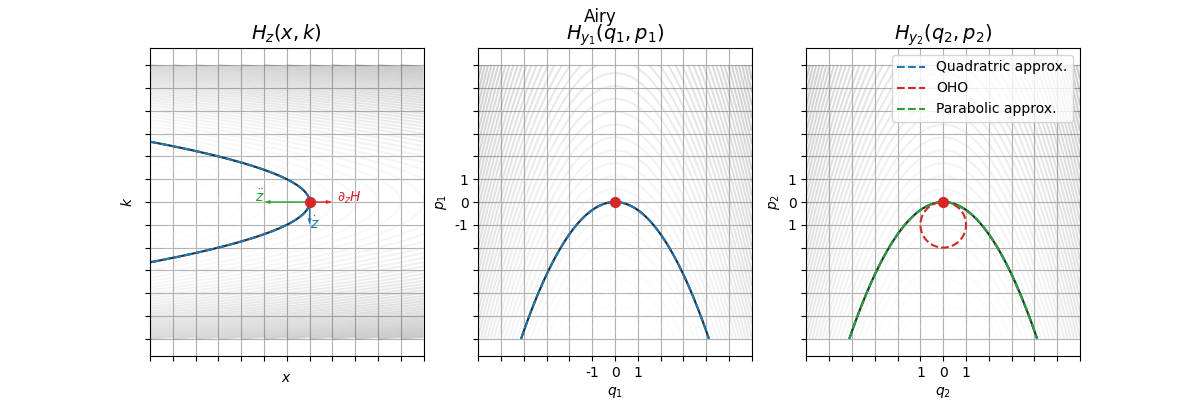

In [32]:
from matplotlib.lines import Line2D

xs = np.linspace(-6, 6, 400)
ks = np.linspace(-6, 6, 400)
X, K = np.meshgrid(xs, ks)

qs = np.linspace(-6, 6, 400)
ps = np.linspace(-6, 6, 400)
Q, P = np.meshgrid(qs, ps)

def setup_axis(ax, title, xlabel, ylabel, xticks, yticks, legend=False):
    ax.grid()
    ax.axis("equal")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(-6, 7, 1), labels=xticks)
    ax.set_yticks(np.arange(-6, 7, 1), labels=yticks)
    if legend:
        ax.legend([])

def plot_contours(ax, X, K, h, levels0=0, levels=None, colors0='k', cmap='Greys', c0alpha=1, alpha=0.2, label=None, **kwargs):
    """Plot contours for the given Hamiltonian."""
    c0 = ax.contour(X, K, h, levels=levels0, colors=colors0, alpha=c0alpha, **kwargs)

    if label is not None:
        handles, labels_ = ax.get_legend_handles_labels()
        if label not in labels_:
            proxy = Line2D([0], [0], color=colors0 if isinstance(colors0, str) else 'k', linestyle=kwargs.get('linestyles', 'solid'), label=label)
            ax.add_line(proxy)
            ax.legend()
    if levels is not None:
        c = ax.contour(X, K, h, levels=levels, cmap=cmap, alpha=alpha)
    else:
        c = None
    return c0, c

def update_contours(X, K, h, c0, c=None, **kwargs):
    """Update contours for the given Hamiltonian."""
    ax = c0.axes
    c0.remove()
    if c is not None:
        c.remove()
    return plot_contours(ax, X, K, h, **kwargs)

def plot_it(it, fig):
    global zt_point, dht_quiver, zdott_quiver, zddott_quiver, dht_label, zdott_label, zddott_label, label_offset, H_y1_c0, H_y1_c, H_y2_c0, H_y2_c, quad_H_z_c0, quad_H_y1_c0, quad_H_y2_c0, quad_H_z_c, quad_H_y1_c, quad_H_y2_c, quad_H_alt_c0, quad_H_alt_c, OHO_c0, OHO_c, parabH_c0, parabH_c
    set_it(it)

    axes = fig.get_axes()
    dht_quiver = axes[0].quiver(xt, kt, dht[0, 0], dht[1, 0], angles='xy', scale_units='xy', scale=1, color='tab:red', width=0.005, zorder=3)
    zdott_quiver = axes[0].quiver(xt, kt, zdott[0, 0], zdott[1, 0], angles='xy', scale_units='xy', scale=1, color='tab:blue', width=0.005, zorder=3)
    zddott_quiver = axes[0].quiver(xt, kt, zddott[0, 0], zddott[1, 0], angles='xy', scale_units='xy', scale=1, color='tab:green', width=0.005, zorder=3)
    zt_point = axes[0].scatter(xt, kt, color='tab:red', label=r'$z(t)$', s=50, zorder=3)

    label_offset = 0.2
    dht_label = axes[0].annotate(r'$\partial_{z} H$', xy=(xt + dht[0, 0] + label_offset * dht[0, 0]/np.linalg.norm(dht), kt + dht[1, 0] + label_offset * dht[1, 0]/np.linalg.norm(dht)), 
            xytext=(5, 5), textcoords='data', color='tab:red')
    zdott_label = axes[0].annotate(r'$\dot{z}$', xy=(xt + zdott[0, 0] + label_offset * zdott[0, 0]/np.linalg.norm(dht), kt + zdott[1, 0] + label_offset * zdott[1, 0]/np.linalg.norm(dht)), 
                xytext=(5, 5), textcoords='data', color='tab:blue')
    zddott_label = axes[0].annotate(r'$\ddot{z}$', xy=(xt + zddott[0, 0] + label_offset * zddott[0, 0]/np.linalg.norm(dht), kt + zddott[1, 0] + label_offset * zddott[1, 0]/np.linalg.norm(dht)), 
                xytext=(5, 5), textcoords='data', color='tab:green')
    
    H_y1_c0, H_y1_c = plot_contours(axes[1], Q, P, H_y1(Q, P), levels0=0, levels=10, colors0='k')
    H_y2_c0, H_y2_c = plot_contours(axes[2], Q, P, H_y2(Q, P), levels0=0, levels=10, colors0='k')
    quad_H_z_c0, quad_H_z_c = plot_contours(axes[0], X, K, quad_H(X, K), levels0=0, colors0='tab:blue', alpha=1, linestyles='dashed')
    quad_H_y1_c0, quad_H_y1_c = plot_contours(axes[1], Q, P, quad_H_y1(Q, P), levels0=0, colors0='tab:blue', alpha=1, linestyles='dashed')
    quad_H_y2_c0, quad_H_y2_c = plot_contours(axes[2], Q, P, quad_H_y2(Q, P), levels0=0, colors0='tab:blue', alpha=1, linestyles='dashed', label='Quadratric approx.')
    OHO_c0, OHO_c = plot_contours(axes[2], Q, P, OHO(Q, P), levels0=0, colors0='tab:red', alpha=1, linestyles='dashed', label='OHO')
    parabH_c0, parabH_c = plot_contours(axes[2], Q, P, parab_H(Q, P), levels0=0, colors0='tab:green', alpha=1, linestyles='dashed', label='Parabolic approx.')

def update_it(it):
    global zt_point, dht_quiver, zdott_quiver, zddott_quiver, dht_label, zdott_label, zddott_label, label_offset, H_y1_c0, H_y1_c, H_y2_c0, H_y2_c, quad_H_z_c0, quad_H_y1_c0, quad_H_y2_c0, quad_H_z_c, quad_H_y1_c, quad_H_y2_c, quad_H_alt_c0, quad_H_alt_c, OHO_c0, OHO_c, parabH_c0, parabH_c
    set_it(it)
    # Update scatter point
    zt_point.set_offsets([[xt, kt]])
    # Update quivers
    dht_quiver.set_UVC(dht[0, 0], dht[1, 0])
    dht_quiver.set_offsets([[xt, kt]])
    zdott_quiver.set_UVC(zdott[0, 0], zdott[1, 0])
    zdott_quiver.set_offsets([[xt, kt]])
    zddott_quiver.set_UVC(zddott[0, 0], zddott[1, 0])
    zddott_quiver.set_offsets([[xt, kt]])
    
    dht_label.set_position((xt + dht[0, 0] + label_offset * dht[0, 0]/np.linalg.norm(dht), kt + dht[1, 0] + label_offset * dht[1, 0]/np.linalg.norm(dht)))
    zdott_label.set_position((xt + zdott[0, 0] + label_offset * zdott[0, 0]/np.linalg.norm(dht), kt + zdott[1, 0] + label_offset * zdott[1, 0]/np.linalg.norm(dht)))
    zddott_label.set_position((xt + zddott[0, 0] + label_offset * zddott[0, 0]/np.linalg.norm(dht), kt + zddott[1, 0] + label_offset * zddott[1, 0]/np.linalg.norm(dht)))

    # Remove old contours before drawing new ones
    H_y1_c0, H_y1_c = update_contours(Q, P, H_y1(Q, P), H_y1_c0, H_y1_c, levels0=0, levels=50, colors0='k')
    H_y2_c0, H_y2_c = update_contours(Q, P, H_y2(Q, P), H_y2_c0, H_y2_c, levels0=0, levels=50, colors0='k')
    quad_H_z_c0, quad_H_z_c = update_contours(X, K, quad_H(X, K), quad_H_z_c0, quad_H_z_c, levels0=0, colors0='tab:blue', alpha=1, linestyles='dashed')
    quad_H_y1_c0, quad_H_y1_c = update_contours(Q, P, quad_H_y1(Q, P), quad_H_y1_c0, quad_H_y1_c, levels0=0, colors0='tab:blue', alpha=1, linestyles='dashed')
    quad_H_y2_c0, quad_H_y2_c = update_contours(Q, P, quad_H_y2(Q, P), quad_H_y2_c0, quad_H_y2_c, levels0=0, colors0='tab:blue', alpha=1, linestyles='dashed')
    OHO_c0, OHO_c = update_contours(Q, P, OHO(Q, P), OHO_c0, OHO_c, levels0=0, colors0='tab:red', alpha=1, linestyles='dashed')
    parabH_c0, parabH_c = update_contours(Q, P, parab_H(Q, P), parabH_c0, parabH_c, levels0=0, colors0='tab:green', alpha=1, linestyles='dashed')
def plot_H(name):
    choose_H(name)
    h = H(X, K)

    fig = plt.figure(num=1); fig.clf(); fig.suptitle(f"{name}", fontsize=12); fig.set_size_inches(12, 4)
    ax1 = fig.add_subplot(1, 3, 1); ax2 = fig.add_subplot(1, 3, 2); ax3 = fig.add_subplot(1, 3, 3)

    setup_axis(ax1, r"$H_z(x,k)$", r"$x$", r"$k$", [], [])
    setup_axis(ax2, r"$H_{y_1}(q_1, p_1)$", r"$q_1$", r"$p_1$", 
               [None, None, None, None, None, -1, 0, 1, None, None, None, None, None], 
               [None, None, None, None, None, -1, 0, 1, None, None, None, None, None])
    setup_axis(ax3, r"$H_{y_2}(q_2, p_2)$", r"$q_2$", r"$p_2$", 
               [None, None, None, None, None, 1, 0, 1, None, None, None, None, None], 
               [None, None, None, None, None, 1, 0, 1, None, None, None, None, None], legend=True)
    
    plot_contours(ax1, X, K, h, levels0=0, levels=50, colors0='k', alpha=0.2)
    ax2.scatter(0, 0, color='tab:red', s=50, zorder=3)#, label=r'$y_1(t)$')
    ax3.scatter(0, 0, color='tab:red', s=50, zorder=3)#, label=r'$y_2(t)$')

    plot_it(0, fig)
    update_it(0)

widgets.interact(plot_H, name=widgets.Dropdown(options=['Airy', 'Weber', 'Himmelblau'], value=name))
slider = IntSlider(value=0, min=0, max=len(zs[0])-1, step=1, description='Time step')
interact(update_it, it=slider)

plt.show()